In [25]:
import os
import numpy as np
import pandas as pd
import librosa

In [26]:

# Load your dataset (you can use your data loading code here)
df = pd.read_csv("dataset_file_directory.csv")
dfs=df[~df['Label'].isin([ 'glee','more','tablet','hunger','greeting','laugh','help','bathroom'])]


dfsd = dfs.copy()
# Define a mapping of old labels to new valence-based labels
valence_mapping = {
       'selftalk'  :   'positive',
    'frustrated'   :   'negative',
    'delighted'    :   'positive',
    'dysregulated' :   'negative',
    'social'       :   'positive',
    'request'      :   'positive',
    'affectionate' :   'positive',
    'yes'          :   'positive',
    'laughter'     :   'positive',
    'dysregulation-sick' : 'negative',
    'happy'   :        'positive',
    'protest'  :       'negative',2
    'dysregulation-bathroom' :'negative',
    'no '    :         'negative',
}



# Update the 'Label' column based on the valence mapping
dfsd['Label'] = dfsd['Label'].map(valence_mapping)

# test_percentage = 0.20
# df20 = dfsd.sample(frac=test_percentage, random_state=42)


In [ ]:
class_labels = df['Label'].unique()
print(class_labels)
print(df['Label'].value_counts())

In [27]:
dfs=df[~df['Label'].isin([ 'glee','more','tablet','hunger','greeting','laugh','help','bathroom'])]
print(dfs['Label'].value_counts())

selftalk                  1885
frustrated                1536
delighted                 1272
dysregulated               704
social                     634
request                    419
affectionate               129
yes                        123
laughter                    93
dysregulation-sick          74
happy                       61
protest                     21
dysregulation-bathroom      18
no                          12
Name: Label, dtype: int64


In [ ]:
#shuffel dataset


In [10]:
df20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1396 entries, 4183 to 1901
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Filename     1396 non-null   object
 1   Participant  1396 non-null   object
 2   Label        1394 non-null   object
dtypes: object(3)
memory usage: 43.6+ KB


In [6]:
import os
import librosa
import numpy as np

def extract_audio_features1(dataset):
    features_list = []
    labels_list = []
    for index, row in dataset.iterrows():
        filename = row['Filename']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None)  # sr=None to preserve the original sample rate

                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
                
                # Calculate Harmonic Ratio
                harmonic_ratio = librosa.effects.harmonic(audio_data)

                # Take the mean of the harmonic ratio to get a single value
                harmonic_ratio_mean = np.mean(harmonic_ratio)

                # Calculate Spectrogram as image-based features
                spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

                # Convert Spectrogram to decibels (dB)
                spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

                # Calculate mean values for each feature
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
                spectrogram_db_mean = np.mean(spectrogram_db, axis=1)

                # Concatenate all features into a single feature vector
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, harmonic_ratio_mean, spectrogram_db_mean))

                # Append the extracted features and label to the lists
                features_list.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            print(f"Audio file not found: {wav_file_path}")

    return np.array(features_list), np.array(labels_list)


In [24]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tensorflow import keras
from tensorflow.keras import layers

# Define the create_model function for the CNN
def create_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Conv1D(256, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Load your dataset (you can use your data loading code here)
# df = pd.read_csv("dataset_file_directory.csv")
test_percentage = 0.40
df20 = df.sample(frac=test_percentage, random_state=42)

# Define the directory where audio files are located
script_dir = r"C:\Users\pawan\Desktop\mv\downloaddataset"
wav_dir = os.path.join(script_dir, "downloaded_wav_files")

# Define a function to extract audio features (you can use your feature extraction code here)
def extract_audio_features(dataset):
    features_list = []
    labels_list = []
    for index, row in dataset.iterrows():
        filename = row['Filename']
        label = row['Label']
        wav_file_path = os.path.join(wav_dir, filename)
        if os.path.exists(wav_file_path):
            try:
                # Load the WAV file using librosa
                audio_data, sample_rate = librosa.load(wav_file_path, sr=None)  # sr=None to preserve the original sample rate

                # Perform feature extraction (e.g., MFCCs)
                mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)
                chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
                spectral_contrast = librosa.feature.spectral_contrast(y=audio_data, sr=sample_rate)
               
                mfccs_mean = np.mean(mfccs, axis=1)
                chroma_mean = np.mean(chroma, axis=1)
                spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
            
                combined_feature_vector = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean))
                # Append the extracted features and label to the lists
                features_list.append(combined_feature_vector)
                labels_list.append(label)

            except Exception as e:
                print(f"Error processing {wav_file_path}: {str(e)}")
        else:
            null_file +=1
            print(f"Audio file not found: {wav_file_path}")

    return np.array(features_list), np.array(labels_list)

# Filter out labels that are not common in the training data
# train_labels = set(df20['Label'].unique())
# df20 = df20[df20['Label'].isin(train_labels)]

# Extract audio features from your dataset
X, y = extract_audio_features1(df20)

# Define LOSO cross-validation with session stratification
logo = LeaveOneGroupOut()

# Initialize a list to store F1 scores
f1_scores = []

# Encode labels using LabelEncoder after filtering labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Iterate over participants using LOSO cross-validation
for train_index, test_index in logo.split(X, y_encoded, groups=df20['Participant']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Define the input shape and number of classes based on your data
    input_shape = X_train.shape[1]
    num_classes = len(train_labels)
    
    # Create the CNN model
    model = create_model(input_shape, num_classes)
    
    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate and print the F1 score for the session
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Append the F1 score to the list
    f1_scores.append(f1)

# Calculate and print the mean F1 score across sessions
mean_f1_score = np.mean(f1_scores)
print("Mean F1 Score:", mean_f1_score)


NameError: name 'p1_datasets' is not defined

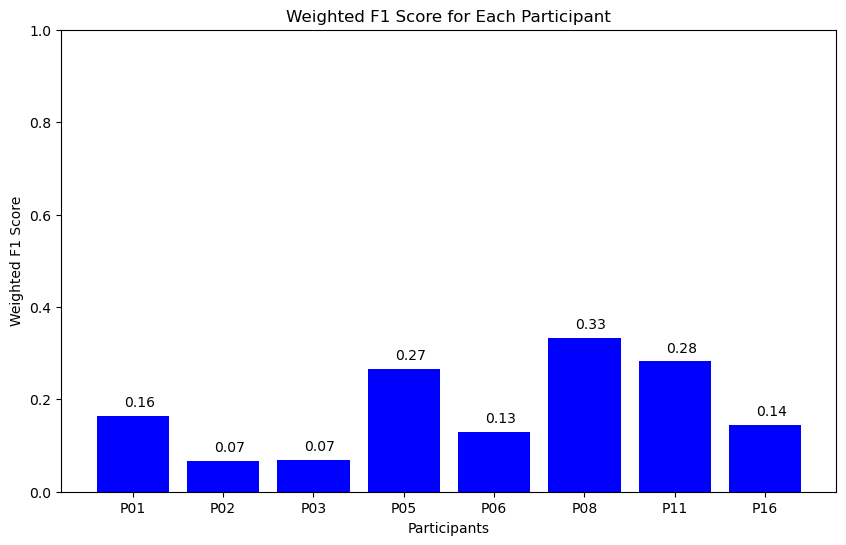

In [5]:
import matplotlib.pyplot as plt

# F1 scores for each participant and their corresponding labels

participants = ["P01", "P02", "P03", "P05", "P06", "P08", "P11", "P16"]

# Plot the F1 scores
plt.figure(figsize=(10, 6))
bars = plt.bar(participants, f1_scores, color='blue')
plt.xlabel('Participants')
plt.ylabel('Weighted F1 Score')
plt.title('Weighted F1 Score for Each Participant')
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1

# Display the F1 scores over the bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{score:.2f}', fontsize=10)

plt.show()


In [25]:
groups=df20['Participant']
print(groups)

5223    P08
3053    P05
5329    P08
3698    P05
3973    P06
       ... 
3035    P05
139     P01
3038    P05
4896    P08
5103    P08
Name: Participant, Length: 2831, dtype: object
